In [1]:
import random
from dataclasses import dataclass
from copy import deepcopy
import time

from tqdm import tqdm
import torch
from torchtyping import TensorType as TT, patch_typeguard

from hand import Transformer, Task, Perfs
from viz.pygame_mainloop import pygame_mainloop_thread_start

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

patch_typeguard()

In [14]:
crash_kernel = pygame_mainloop_thread_start(globals())

pygame 2.1.3 (SDL 2.26.4, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Assets: /home/diego/ai/hand-transformer/viz/assets
Images: /home/diego/ai/hand-transformer/viz/assets/images


In [137]:
crash_kernel()

Traceback (most recent call last):
  File "/home/diego/ai/hand-transformer/viz/pygame_mainloop.py", line 21, in run_app
    pyapp.run()
  File "/home/diego/ai/hand-transformer/viz/engine/app.py", line 62, in run
    self.clock.tick(self.state.FPS)
AttributeError: 'NoneType' object has no attribute 'FPS'



SystemExit: 

/home/diego/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


App crashed!!!


In [3]:
class ArithmeticTask(Task):

    def __init__(self, prompt_len: int = 100,
                    max_number: int = 1000,
                    ops: tuple[str, ...] = ("+",),
                    max_operends: int = 2,
                    parens_prob: float = 0,
                    allow_negative: bool = False,
                    max_decimals: int = 0) -> None:
        self.max_number = max_number
        self.ops = ops
        self.max_operends = max_operends
        self.parens_prob = parens_prob
        self.allow_negative = allow_negative
        self.max_decimals = max_decimals

        super().__init__(list("0123456789.+-*=()/%^"), prompt_len, pad_token="_")

    def construct(self, n_operends) -> str:
        if n_operends == 1:
            if self.allow_negative:
                mini = -self.max_number
            else:
                mini = 0
            if self.max_decimals > 0:
                rounding = random.randrange(0, self.max_decimals)
                return str(round(random.uniform(mini, self.max_number), rounding))
            else:
                return str(random.randrange(mini, self.max_number))

        if n_operends == self.max_operends and random.random() > 1 / self.max_operends:
            return self.construct(random.randrange(1, self.max_operends))
        
        n_ops_left = random.randrange(1, n_operends)
        a = self.construct(n_ops_left)
        b = self.construct(n_operends - n_ops_left)
        op = random.choice(self.ops)
        ret = f"{a}{op}{b}"
        if random.random() < self.parens_prob:
            ret = f"({ret})"
        return ret

    def dataset_size(self, n_operands=None) -> int:
        if n_operands is None:
            n_operands = self.max_operends

        if n_operands == 1:
            if self.allow_negative:
                range_ = self.max_number * 2
            else:
                range_ = self.max_number
            return range_ * 10 ** self.max_decimals

        if self.parens_prob > 0:
            raise NotImplementedError("Parentheses are not supported yet")

        item_possibilities = self.dataset_size(1)
        total = 0
        for n_ops in range(n_operands):
            total += item_possibilities ** (n_ops + 1) * len(self.ops) ** n_ops
        return total
            

        

    def generate(self, batch_size: str, unique=True, max_tries=30) -> tuple[list[str], list[str]]:
        prompts = []
        answers = [] 
        tries = 0
        while len(prompts) < batch_size:
            c = self.construct(self.max_operends)
            try:
                res = str(eval(c))
            except:
                res = 'nan'

            cut = random.randrange(0, len(res))
            prompt = f"{c}={res[:cut]}"
            answer = res[cut]

            if len(prompt) > self.prompt_len:
                continue
            if unique and prompt in prompts:
                tries += 1
                if tries > max_tries:
                    break
                continue

            prompts.append(prompt)
            answers.append(answer)
            tries = 0

        return prompts, answers

In [10]:
task = ArithmeticTask(
    prompt_len=20,
    max_number=56,
    ops=("+",),
    max_operends=2,
    parens_prob=0,
    allow_negative=False,
    max_decimals=0,
)
task.dataset_size()

3192

In [5]:
model = Transformer(
    voc_size=len(task.tokens),
    embedding_size=64,
    depth=4,
    heads=4,
    max_prompt_len=task.prompt_len,
    mlp_dims=(64 * 4,),
)
model.init_weights()
optim = torch.optim.SGD(model.parameters(), lr=5e-5, weight_decay=5e-6, momentum=0.95)
perfs = Perfs([100])
saves = []

In [ ]:
@dataclass
class Save:
    model: dict
    timestamp: float
    note: str

saves: list[Save] = []
saves = torch.load("saves.pt")

In [26]:
def save(note: str = "no comment"):
    saves.append(Save(
        deepcopy(model.state_dict()),
        time.time(),
        note,
    ))
    torch.save(saves, "saves.pt")
    print(f"Saved model state to {len(saves) - 1}, note: {note} at {time.ctime()}")
def recall(n=-1):
    model.load_state_dict(deepcopy(saves[n].model))
    n = len(saves) + n if n < 0 else n
    print(f"Recalled model state from {n} note: {saves[n].note} ({len(saves) - 1} total saves)")
def set_hyperparams(optim, lr=None, weight_decay=None, momentum=None):
    for g in optim.param_groups:
        if lr is not None:
            g['lr'] = lr
        if weight_decay is not None:
            g['weight_decay'] = weight_decay
        if momentum is not None:
            g['momentum'] = momentum
def call_once(f):
    called = False
    def wrapper(*args, **kwargs):
        nonlocal called
        if not called:
            called = True
            return f(*args, **kwargs)
    return wrapper


In [7]:
recall(-1)

Recalled model state from 40 note: Learned to add up to 56 (40 total saves)


In [55]:
lr = 5e-5
weight_decay = 1e-6
def curriculum():
    global lr
    def loss(last=10):
        if len(perfs.loss) < last:
            return 100
        return sum(perfs.loss[-last:]) / last

    def variance(last=10):
        if len(perfs.loss) < last:
            return 100
        return torch.var(torch.tensor(perfs.loss[-last:]))

    # model.init_weights()
    steps = 0
    while True:
        steps += 1
        yield

        if steps > 10 and loss() < 0.001:
            steps = 0
            lr = 5e-5
            set_hyperparams(optim, lr, weight_decay)
            save(f"Learned to add up to {task.max_number-1}")
            if task.max_number < 650:
                task.max_number += 1 + task.max_number // 15
            else:
                task.allow_negative = True

        # if steps > 20 and variance(20) > loss(20):
        #     steps = 0
        #     lr *= 0.7
        #     lr = max(lr, 1e-5)
        #     set_hyperparams(optim, lr, weight_decay)

        # if loss doesn't go down much, increase learning rate
        if steps > 50 and lr < 70e-5 and abs(loss(50) - loss(10)) < 0.1:
            steps = 0
            lr *= 1.3
            lr = min(lr, 70e-5)
            set_hyperparams(optim, lr, weight_decay)
curr = curriculum()

Saved model state to 72, note: Learned to add up to 649 at Fri Mar 17 10:54:34 2023


In [56]:
@call_once
def modify():
    global lr, weight_decay
    lr = 1e-3
    weight_decay = 1e-5
    set_hyperparams(optim, lr=lr, momentum=0.98, weight_decay=weight_decay)
    # with torch.no_grad():
    #     emb = model.embedding.weight
        # emb[-1] = 0


In [59]:
batch_size = 1000
def logic():
    return
    next(curr)
    modify()

    x, y = task.generate_batch(batch_size)
    optim.zero_grad()
    loss = model.loss(x, y)
    loss.backward()
    optim.step()
    perfs.update(loss, model, task)

In [12]:
while True:
    logic()

Saved model state to 41, note: Learned to add up to 55 at Fri Mar 17 04:55:22 2023
Saved model state to 42, note: Learned to add up to 59 at Fri Mar 17 04:57:50 2023
Saved model state to 43, note: Learned to add up to 64 at Fri Mar 17 05:01:22 2023
Saved model state to 44, note: Learned to add up to 69 at Fri Mar 17 05:04:19 2023
Saved model state to 45, note: Learned to add up to 74 at Fri Mar 17 05:07:28 2023
Saved model state to 46, note: Learned to add up to 80 at Fri Mar 17 05:10:09 2023
Saved model state to 47, note: Learned to add up to 86 at Fri Mar 17 05:13:22 2023
Saved model state to 48, note: Learned to add up to 92 at Fri Mar 17 05:16:38 2023
Saved model state to 49, note: Learned to add up to 99 at Fri Mar 17 05:20:05 2023
Saved model state to 50, note: Learned to add up to 106 at Fri Mar 17 05:28:49 2023
Saved model state to 51, note: Learned to add up to 114 at Fri Mar 17 05:39:05 2023
Saved model state to 52, note: Learned to add up to 122 at Fri Mar 17 05:51:16 2023
S

KeyboardInterrupt: 

# Pygame vizualization

In [16]:
from viz.utils import *
from viz.engine import *

In [62]:
prompts = answers = None
avg_acc = 0

def new_prompts_to_show():
    global prompts, answers, avg_acc
    prompts, answers = task.generate(10000, False, 100)

    # pick only the few worst and few best
    pred: TT = model(task.encode(prompts, task.prompt_len))
    
    answers_pos = task.encode(answers)
    correct_proba = torch.gather(pred.softmax(1), 1, answers_pos).squeeze()
    avg_acc = correct_proba.mean().item()

    losses = torch.nn.functional.cross_entropy(pred, task.encode(answers).squeeze(), reduction="none")
    losses, idx = losses.sort()

    idx = torch.cat([idx[:-20:len(idx)//10], idx[-20::2]])
    prompts = [prompts[i] for i in idx]
    answers = [answers[i] for i in idx]
new_prompts_to_show()

def draw(gfx: GFX):
    return
    with torch.no_grad():
        # if random.random() < 1 / (30 * 2):
        #     new_prompts_to_show()
        losses = torch.tensor(perfs.loss[-500:])
        r = gfx.plot(losses, "orange", "Loss", axis=1, topleft=(100, 100))
        gfx.plot(losses.clamp_max(0.1), "orange", "Loss", axis=1, topleft=r.topright)
        r.inflate_ip(0, 20)
        pred: TT['batch', 'token'] = model(task.encode(prompts, task.prompt_len))
        for p, a, g in zip(prompts, answers, pred):
            if p == prompts[-10]:
                r.y += 20
            g = g.softmax(0)
            p = task.pad_token * (task.prompt_len - len(p)) + p
            r = gfx.text(f"{p} → {a}", topleft=r.bottomleft)
            r2 = r.inflate(40, 0)
            for prob, t in zip(g, task.tokens):
                color = mix((0, 0, 0), (255, 0, 0), prob.item())
                r2 = gfx.text(f"{t}", color=color, topleft=r2.topright)
            # add prob of correct answer as %
            r2 = gfx.text(f"  {g[task.tokens.index(a)].item():.0%}", topleft=r2.topright)

        # using torch.gather
        answer_positions = task.encode(answers)
        correct_proba = torch.gather(pred.softmax(1), 1, answer_positions).squeeze()
        # accuracy = correct_proba.mean().item()

        worse_accuracy = correct_proba.min().item()

    r = gfx.texts(
        f"epoch: {len(perfs.loss)}",
        f"max_number: {task.max_number-1}",
        f"avg accuracy: {avg_acc:.1%}",
        f"worst accuracy: {worse_accuracy:.0%}",
        f"loss: {sum(losses[-10:])/10:.5f}",
        f"target loss: {2 / task.dataset_size():.5f}",
        f"lr: {lr:.5f}",
        f"weight_decay: {weight_decay}",
        topleft=r.bottomleft + Vec2(0, 10))
    # transformer_outline(gfx, model, r.bottomleft)
    model.blocks[0]: TransformerBlock
    # draw_matrix(gfx, model.blocks[2].attention.heads[3].qk(), 20, "Embedding", topleft=r.bottomleft)

In [40]:
print("Dataset size:", task.dataset_size())
for s in saves[-10:]:
    delta = s.timestamp - saves[0].timestamp
    # human readable fmt
    delta = f"{delta // 60:.0f}:{delta % 60:.0f}"
    print(f"{delta} {s.note}")

Dataset size: 423150
295:45 Learned to add up to 242
305:3 Learned to add up to 259
315:52 Learned to add up to 277
329:52 Learned to add up to 296
346:55 Learned to add up to 316
359:52 Learned to add up to 338
376:14 Learned to add up to 361
386:51 Learned to add up to 386
400:19 Learned to add up to 412
409:49 Learned to add up to 440


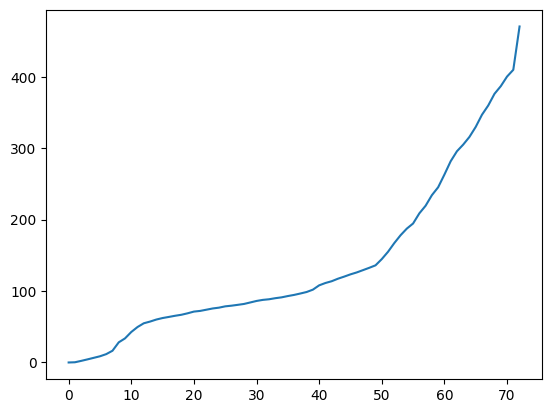

In [57]:
# plot times of saves
times = [s.timestamp - saves[1].timestamp for s in saves[1:]]
maxis = [int(s.note.rpartition(" ")[-1]) for s in saves[1:]]
plt.plot([(s.timestamp - saves[0].timestamp) / 60 for s in saves])

In [60]:
save("88% accuracy up to ± 649")

Saved model state to 73, note: 88% accuracy up to ± 649 at Fri Mar 17 11:30:21 2023
